In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
from sklearn.preprocessing import *
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

import functools

import seaborn as sns
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import keras
from keras import Input, Model
from keras.layers import Dense, LeakyReLU, concatenate
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
def get_dataset(samples_num=20):
  
    
    theta = np.linspace(-2*np.pi + 4*np.random.random()*np.pi, 2*np.pi + 4*np.random.random()*np.pi, samples_num)
    z = np.linspace(0, 4, samples_num)
    #r = 1 + np.random.random()
    r = 1 - np.random.random()*0.4
    x = r * np.sin(theta)
    y = r * np.cos(theta)
   
    return x,y,z

In [ ]:
x = []
y = []
z = []

# generate 1000 spirals
for i in range(1000):
    xx, yy, zz = get_dataset()
    x.append(xx)
    y.append(yy)
    z.append(zz)
    
x = np.array(x)
y = np.array(y)
z = np.array(z)

x.shape

(1000, 20)

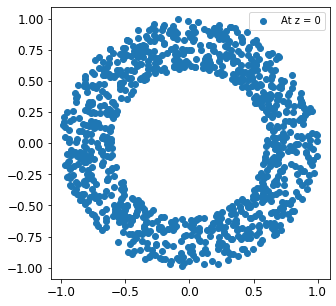

In [ ]:
# At time=0, the points(x,y) of the spirals locate in concentric circles

plt.figure(figsize=(5,5))
plt.scatter(x[:,0], y[:,0], label='At z = 0')
plt.legend()
plt.show()

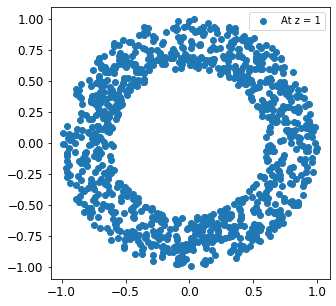

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(x[:,9], y[:,9], label='At z = 1')
plt.legend()
plt.show()

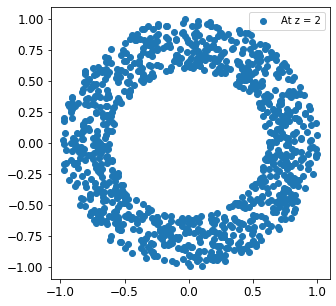

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(x[:,19], y[:,19], label='At z = 2')
plt.legend()
plt.show()

In [ ]:
# plt.figure(figsize=(5,5))
# plt.scatter(x[:,29], y[:,29], label='At z = 3')
# plt.legend()
# plt.show()

In [ ]:
# # At the last timestep, the points(x,y) of the spirals locate in concentric circles

# plt.figure(figsize=(5,5))
# plt.scatter(x[:,-1], y[:,-1], label = 'At z = 4')
# plt.legend()
# plt.show()

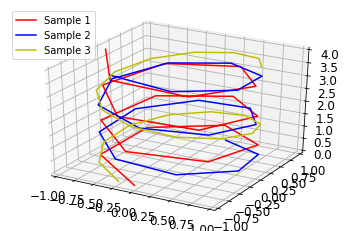

In [ ]:
#%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot3D(x[0,:], y[0,:], z[0,:], 'r', label='Sample 1')
ax.plot3D(x[1,:], y[1,:], z[1,:], 'b', label='Sample 2')
ax.plot3D(x[2,:], y[2,:], z[2,:], 'y', label='Sample 3')

ax.legend()
plt.show()

In [ ]:
#scaler = MinMaxScaler()
samples_num = 1000
dataset = []
for i in range(samples_num):
    sample_data = np.concatenate((x[i,:].reshape(-1,1), y[i,:].reshape(-1,1)), axis=1)
    #X_train_scaled = scaler.fit_transform(sample_data)*2 - 1
    dataset.append(sample_data)
    #dataset.append(sample_data)

dataset = np.array(dataset)
dataset.shape
# dataset[0,:,:]

(1000, 20, 2)

In [ ]:
BATCH_SIZE = 32
latent_space = 3

In [ ]:
# Create a tensorflow dataset and split it into batches
train_dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], dataset.shape[2], 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(dataset))
train_dataset = train_dataset.batch(BATCH_SIZE)
num=0
for data in train_dataset:
    print("every time the data shape",data.shape)
    num+=1

print("Cycles: ",num)

every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the data shape (32, 20, 2, 1)
every time the d

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(keras.layers.Dense(10*2*1, use_bias=False, input_shape=(latent_space, )))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((10, 2, 1)))

    #model.add(Reshape((int(latent_space/2), 2, 1), input_shape=(latent_space,)))

    model.add(keras.layers.Conv2D(16, (8, 2), strides=(1, 2), padding='same'))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2D(32, (8, 2), strides=(2, 1), padding='same'))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(32, (8, 2), strides=(1, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    model.add(keras.layers.Conv2DTranspose(16, (8, 2), strides=(2, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    model.add(keras.layers.Conv2DTranspose(1, (8, 2), strides=(2, 1), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                60        
_________________________________________________________________
batch_normalization_3 (Batch (None, 20)                80        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 2, 1)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 1, 16)         272       
_________________________________________________________________
layer_normalization_3 (Layer (None, 10, 1, 16)         32        
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 10, 1, 16)        

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(32, (8, 2), strides=(2, 1), padding='same',
                                     input_shape=[20, 2, 1]))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Conv2D(64, (8, 2), strides=(2, 1), padding='same'))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.2))
#     model.add(keras.layers.Conv2D(128, (2, 2), strides=(2, 1), padding='same'))
#     model.add(keras.layers.LayerNormalization())
#     model.add(keras.layers.LeakyReLU())
#     model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 10, 2, 32)         544       
_________________________________________________________________
layer_normalization_5 (Layer (None, 10, 2, 32)         64        
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 10, 2, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 2, 32)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 2, 64)          32832     
_________________________________________________________________
layer_normalization_6 (Layer (None, 5, 2, 64)          128       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 5, 2, 64)         

In [ ]:
gan = keras.models.Sequential([generator, discriminator])
gan.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 20, 2, 1)          33756     
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 34209     
Total params: 67,965
Trainable params: 67,829
Non-trainable params: 136
_________________________________________________________________


In [ ]:
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

def discriminator_loss(real_output,fake_output):
    return tf.reduce_mean(fake_output)-tf.reduce_mean(real_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

In [ ]:
def gradient_penalty(f, real, fake):
    
    def _interpolate(a, b):
        shape = [tf.shape(a)[0]] + [1] * (a.shape.ndims - 1)
        alpha = tf.random.uniform(shape=shape, minval=0., maxval=1.)
        inter = a + alpha * (b - a)
        inter.set_shape(a.shape)
        return inter

    x = _interpolate(real, fake)
    with tf.GradientTape() as t:
        t.watch(x)
        pred = f(x)
    grad = t.gradient(pred, x)
    norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
    gp = tf.reduce_mean((norm - 1.)**2)

    return gp

In [ ]:
@tf.function
def train_G(batch):
    with tf.GradientTape() as gen_tape:
        if batch.shape[0]==BATCH_SIZE:
            noise = tf.random.normal([BATCH_SIZE, latent_space])
        else:
            noise = tf.random.normal([batch.shape[0]%BATCH_SIZE, latent_space])
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


    return gen_loss

In [ ]:
@tf.function
def train_D(batch):
    with tf.GradientTape() as disc_tape:
        if batch.shape[0]==BATCH_SIZE:
            noise = tf.random.normal([BATCH_SIZE, latent_space])
        else:
            noise = tf.random.normal([batch.shape[0]%BATCH_SIZE, latent_space])

        generated_images = generator(noise, training=True)

        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss_without = discriminator_loss(real_output, fake_output)
        gp = gradient_penalty(functools.partial(discriminator, training=True), batch, generated_images)
        disc_loss = discriminator_loss(real_output, fake_output) + gp*10.0

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return disc_loss_without

In [ ]:
#current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
generator_log_dir = './content/generator'
discriminator_log_dir = './content/discriminator'

generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)
discriminator_summary_writer = tf.summary.create_file_writer(discriminator_log_dir)

In [ ]:
generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

In [ ]:
n_critic = 5
num_examples_to_generate = 5
seed = tf.random.normal([num_examples_to_generate, latent_space])

In [ ]:
def train(dataset, epochs):
    hist = []
    for epoch in range(epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch + 1, epochs))   

        for batch in dataset:

            for _ in range(n_critic):
                disc_loss_without = train_D(batch)

            gen_loss = train_G(batch)
            

            generator_mean_loss(gen_loss)
            discriminator_mean_loss(disc_loss_without)
        
        with generator_summary_writer.as_default():
            tf.summary.scalar('generator_loss', generator_mean_loss.result(), step=epoch)

        with discriminator_summary_writer.as_default():
            tf.summary.scalar('discriminator_loss', discriminator_mean_loss.result(), step=epoch)
        
        hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])

        generator_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()
        
        print("discriminator: {:.6f}".format(hist[-1][1]), end=' - ')
        print("generator: {:.6f}".format(hist[-1][0]), end=' - ')    
        print('{:.0f}s'.format( time.time()-start))

        # Global variables are used below
        if epoch%100 == 0:
            #save the model
            gan.save('./content/'+'wgan'+str(epoch)+'.h5')    

            # plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[10,5])
            ax.plot(hist)
            ax.legend(['loss_gen', 'loss_disc'])
            #ax.set_yscale('log')
            ax.grid()
            plt.show()
            
    return hist


Epoch 1/501
discriminator: -0.431993 - generator: 0.253884 - 8s
Loss: 


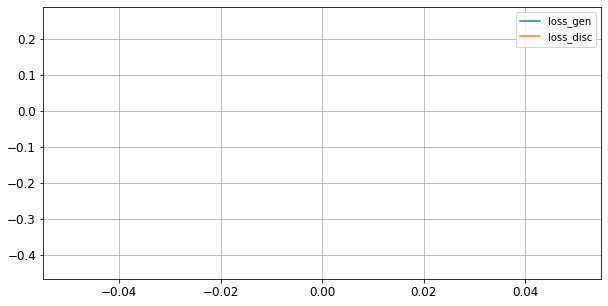

Epoch 2/501
discriminator: -0.761454 - generator: 0.545153 - 1s
Epoch 3/501
discriminator: -0.697404 - generator: 0.698619 - 1s
Epoch 4/501
discriminator: -0.792830 - generator: 0.952686 - 1s
Epoch 5/501
discriminator: -0.823695 - generator: 1.281034 - 1s
Epoch 6/501
discriminator: -0.761238 - generator: 1.639207 - 1s
Epoch 7/501
discriminator: -0.822159 - generator: 1.921062 - 1s
Epoch 8/501
discriminator: -0.864162 - generator: 2.057668 - 1s
Epoch 9/501
discriminator: -0.821574 - generator: 2.095673 - 1s
Epoch 10/501
discriminator: -0.830910 - generator: 2.181468 - 1s
Epoch 11/501
discriminator: -0.795147 - generator: 2.080974 - 1s
Epoch 12/501
discriminator: -0.796170 - generator: 2.081251 - 1s
Epoch 13/501
discriminator: -0.785640 - generator: 2.116508 - 1s
Epoch 14/501
discriminator: -0.758750 - generator: 1.960698 - 1s
Epoch 15/501
discriminator: -0.696867 - generator: 1.696056 - 1s
Epoch 16/501
discriminator: -0.691581 - generator: 1.449526 - 1s
Epoch 17/501
discriminator: -0.74

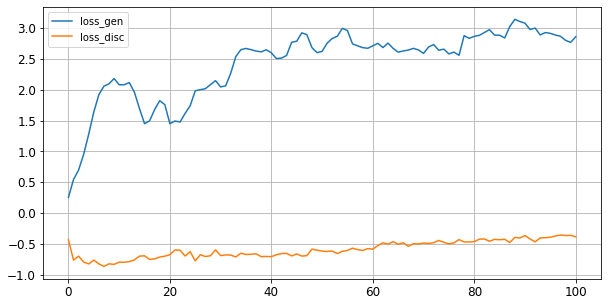

Epoch 102/501
discriminator: -0.320430 - generator: 2.845956 - 1s
Epoch 103/501
discriminator: -0.354358 - generator: 2.886335 - 1s
Epoch 104/501
discriminator: -0.349750 - generator: 2.862866 - 1s
Epoch 105/501
discriminator: -0.354786 - generator: 2.845251 - 1s
Epoch 106/501
discriminator: -0.349551 - generator: 3.046475 - 1s
Epoch 107/501
discriminator: -0.339797 - generator: 2.967698 - 1s
Epoch 108/501
discriminator: -0.349598 - generator: 2.943828 - 1s
Epoch 109/501
discriminator: -0.358047 - generator: 2.830266 - 1s
Epoch 110/501
discriminator: -0.305337 - generator: 2.873478 - 1s
Epoch 111/501
discriminator: -0.308655 - generator: 2.841925 - 1s
Epoch 112/501
discriminator: -0.309598 - generator: 2.871027 - 1s
Epoch 113/501
discriminator: -0.349349 - generator: 2.856128 - 1s
Epoch 114/501
discriminator: -0.332443 - generator: 2.819897 - 1s
Epoch 115/501
discriminator: -0.302238 - generator: 2.883727 - 1s
Epoch 116/501
discriminator: -0.288168 - generator: 2.904624 - 1s
Epoch 117/

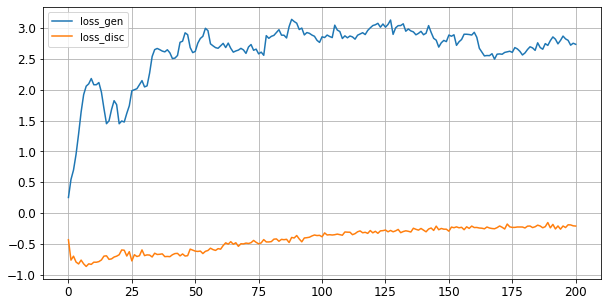

Epoch 202/501
discriminator: -0.266735 - generator: 2.734721 - 1s
Epoch 203/501
discriminator: -0.152215 - generator: 2.681810 - 1s
Epoch 204/501
discriminator: -0.228732 - generator: 2.747382 - 1s
Epoch 205/501
discriminator: -0.185524 - generator: 2.829503 - 1s
Epoch 206/501
discriminator: -0.198049 - generator: 2.849499 - 1s
Epoch 207/501
discriminator: -0.176905 - generator: 2.845905 - 1s
Epoch 208/501
discriminator: -0.210663 - generator: 2.804204 - 1s
Epoch 209/501
discriminator: -0.213721 - generator: 2.895222 - 1s
Epoch 210/501
discriminator: -0.234458 - generator: 2.736460 - 1s
Epoch 211/501
discriminator: -0.183156 - generator: 2.719170 - 1s
Epoch 212/501
discriminator: -0.193872 - generator: 2.782214 - 1s
Epoch 213/501
discriminator: -0.209453 - generator: 2.708285 - 1s
Epoch 214/501
discriminator: -0.184989 - generator: 2.759952 - 1s
Epoch 215/501
discriminator: -0.192787 - generator: 2.716002 - 1s
Epoch 216/501
discriminator: -0.204943 - generator: 2.709455 - 1s
Epoch 217/

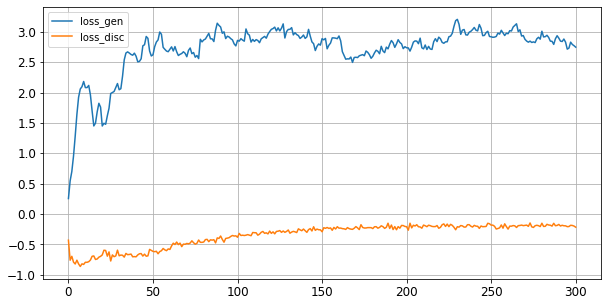

Epoch 302/501
discriminator: -0.210729 - generator: 2.672447 - 1s
Epoch 303/501
discriminator: -0.272403 - generator: 2.627731 - 1s
Epoch 304/501
discriminator: -0.206448 - generator: 2.640378 - 1s
Epoch 305/501
discriminator: -0.190370 - generator: 2.651084 - 1s
Epoch 306/501
discriminator: -0.219010 - generator: 2.648623 - 1s
Epoch 307/501
discriminator: -0.195172 - generator: 2.607400 - 1s
Epoch 308/501
discriminator: -0.192148 - generator: 2.677099 - 1s
Epoch 309/501
discriminator: -0.168540 - generator: 2.599676 - 1s
Epoch 310/501
discriminator: -0.153070 - generator: 2.628440 - 1s
Epoch 311/501
discriminator: -0.184063 - generator: 2.602272 - 1s
Epoch 312/501
discriminator: -0.207409 - generator: 2.611272 - 1s
Epoch 313/501
discriminator: -0.203409 - generator: 2.474154 - 1s
Epoch 314/501
discriminator: -0.180834 - generator: 2.507348 - 1s
Epoch 315/501
discriminator: -0.183289 - generator: 2.516582 - 1s
Epoch 316/501
discriminator: -0.200137 - generator: 2.470856 - 1s
Epoch 317/

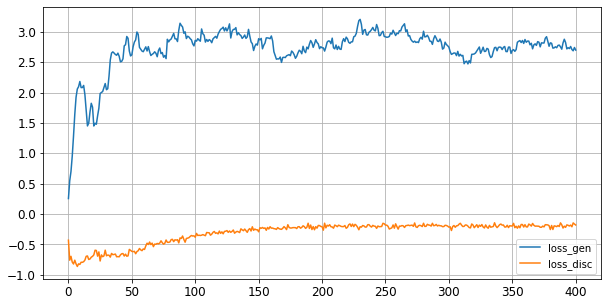

Epoch 402/501
discriminator: -0.151822 - generator: 2.691464 - 1s
Epoch 403/501
discriminator: -0.212600 - generator: 2.609331 - 1s
Epoch 404/501
discriminator: -0.183321 - generator: 2.648555 - 1s
Epoch 405/501
discriminator: -0.190688 - generator: 2.714025 - 1s
Epoch 406/501
discriminator: -0.194561 - generator: 2.697757 - 1s
Epoch 407/501
discriminator: -0.208432 - generator: 2.675975 - 1s
Epoch 408/501
discriminator: -0.211272 - generator: 2.747575 - 1s
Epoch 409/501
discriminator: -0.218609 - generator: 2.772533 - 1s
Epoch 410/501
discriminator: -0.177001 - generator: 2.756999 - 1s
Epoch 411/501
discriminator: -0.138074 - generator: 2.837679 - 1s
Epoch 412/501
discriminator: -0.201718 - generator: 2.699389 - 1s
Epoch 413/501
discriminator: -0.201897 - generator: 2.824688 - 1s
Epoch 414/501
discriminator: -0.199871 - generator: 2.852946 - 1s
Epoch 415/501
discriminator: -0.177126 - generator: 2.815874 - 1s
Epoch 416/501
discriminator: -0.171393 - generator: 2.864879 - 1s
Epoch 417/

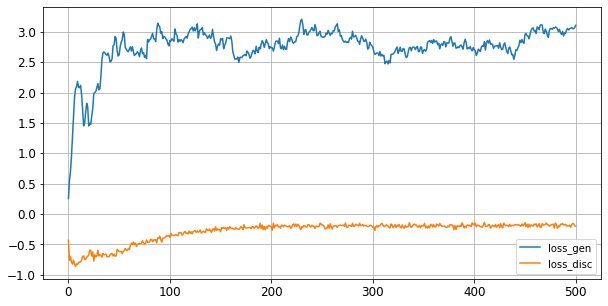

In [ ]:
%matplotlib inline
hist = train(train_dataset, epochs=501)

In [ ]:
latent_values = tf.random.normal([1,latent_space])
#aa = scaler.inverse_transform((generator.predict(tf.convert_to_tensor(latent_values)).reshape(20, 2)+1)/2)

aa = generator.predict(tf.convert_to_tensor(latent_values)).reshape(20, 2)

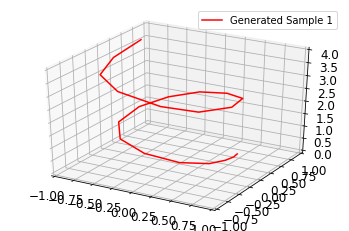

In [ ]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')


ax.plot3D(aa[:,0], aa[:,1], z[0,:], 'r', label='Generated Sample 1')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.legend()
plt.show()

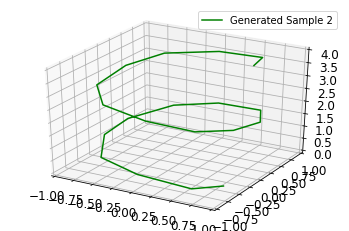

In [ ]:
latent_values = tf.random.normal([1,latent_space])
#aa = scaler.inverse_transform((generator.predict(tf.convert_to_tensor(latent_values)).reshape(20, 2)+1)/2)
aa = generator.predict(tf.convert_to_tensor(latent_values)).reshape(20, 2)
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot3D(aa[:,0], aa[:,1], z[0,:], 'g', label='Generated Sample 2')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.legend()
plt.show()

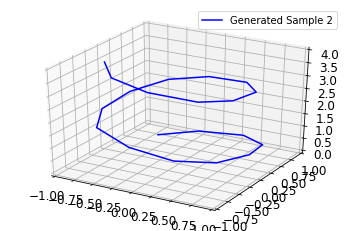

In [ ]:
latent_values = tf.random.normal([1,latent_space])
#aa = scaler.inverse_transform((generator.predict(tf.convert_to_tensor(latent_values)).reshape(20, 2)+1)/2)
aa = generator.predict(tf.convert_to_tensor(latent_values)).reshape(20, 2)

fig = plt.figure()
ax = fig.gca(projection='3d')


ax.plot3D(aa[:,0], aa[:,1], z[0,:], 'b', label='Generated Sample 2')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.legend()
plt.show()

In [ ]:
codings_size = 2
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(1e-2)

def mse_loss(inp, outp):
    inp = tf.reshape(inp, [-1, codings_size])
    outp = tf.reshape(outp, [-1, codings_size])
    return mse(inp, outp)

In [ ]:
#@tf.function
def opt_step(latent_values, real_coding, num_predefined):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        #loss = mse_loss(real_coding, gen_output)
        loss = mse_loss(real_coding, gen_output[:,:num_predefined,:,:])   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [ ]:
def optimize_coding(real_coding, num_predefined):
    latent_values = tf.random.normal([len(real_coding), latent_size], mean=0.0, stddev=0.1)
#     latent_values = tf.random.normal([len(real_coding), latent_size])  
    latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(10000):
        loss.append(opt_step(latent_values, real_coding, num_predefined).numpy())
                            
    plt.plot(loss)
    plt.grid()
    plt.show
        
    return latent_values  #returns the optimized input that generates the desired output

In [ ]:
n = 0
num_predefined = 10
real_coding = dataset[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*num_predefined]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

Loss:  0.0065567354
<tf.Variable 'Variable:0' shape=(1, 3) dtype=float32, numpy=array([[-0.22517839,  0.24938142, -0.30160415]], dtype=float32)>


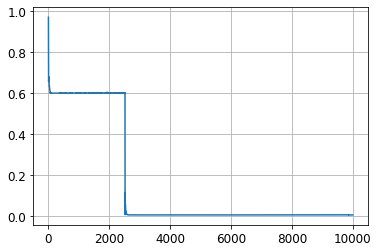

In [ ]:
latent_size = 3
latent_values = optimize_coding(real_coding, num_predefined)
print('Loss: ', mse_loss(generator(latent_values)[:,:num_predefined,:,:], real_coding).numpy())
print(latent_values)

In [ ]:
X_generated = generator.predict(tf.convert_to_tensor(latent_values)).reshape(20,codings_size)
#X_generated = pca_compressed.inverse_transform(X_generated)
X_generated = X_generated.reshape(20, 2)

In [ ]:
X_real = dataset[n].reshape(20, codings_size)
#X_real = pca_compressed.inverse_transform(X_real)
X_real = X_real.reshape(20, 2)

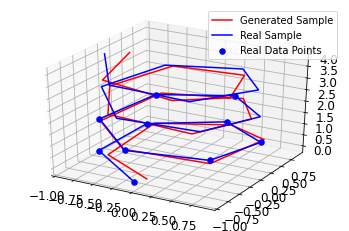

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')


ax.plot3D(X_generated[:,0], X_generated[:,1], z[0,:], 'r', label='Generated Sample')
ax.plot3D(X_real[:,0], X_real[:,1], z[0,:], 'b', label='Real Sample')
ax.scatter3D(X_real[:num_predefined, 0], X_real[:num_predefined, 1], z[0,:num_predefined], c='b', s=30, depthshade=False, label='Real Data Points')

ax.legend()
plt.show()

Loss:  0.0025636437
<tf.Variable 'Variable:0' shape=(1, 3) dtype=float32, numpy=array([[-0.15805767, -0.34799063, -0.17982343]], dtype=float32)>


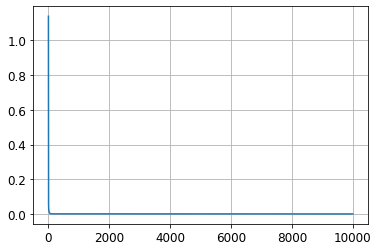

In [ ]:
n = 5
num_predefined = 10
real_coding = dataset[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*num_predefined]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_size = 3
latent_values = optimize_coding(real_coding, num_predefined)
print('Loss: ', mse_loss(generator(latent_values)[:,:num_predefined,:,:], real_coding).numpy())
print(latent_values)


In [ ]:
X_generated = generator.predict(tf.convert_to_tensor(latent_values)).reshape(20,codings_size)
#X_generated = pca_compressed.inverse_transform(X_generated)
X_generated = X_generated.reshape(20, 2)

X_real = dataset[n].reshape(20, codings_size)
#X_real = pca_compressed.inverse_transform(X_real)
X_real = X_real.reshape(20, 2)

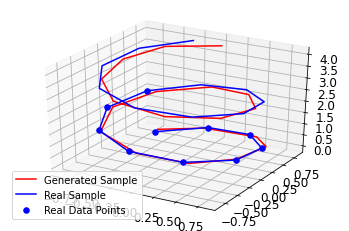

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')


ax.plot3D(X_generated[:,0], X_generated[:,1], z[0,:], 'r', label='Generated Sample')
ax.plot3D(X_real[:,0], X_real[:,1], z[0,:], 'b', label='Real Sample')
ax.scatter3D(X_real[:num_predefined, 0], X_real[:num_predefined, 1], z[0,:num_predefined], c='b', s=30, depthshade=False, label='Real Data Points')

ax.legend()
plt.show()

Loss:  0.34190327
<tf.Variable 'Variable:0' shape=(1, 3) dtype=float32, numpy=array([[ 0.09802141, -0.04111823, -0.10703027]], dtype=float32)>


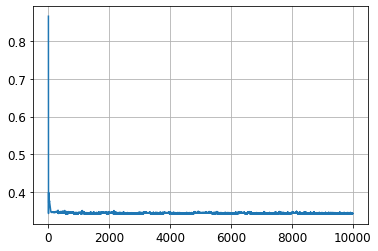

In [ ]:
n = 100
num_predefined = 10
real_coding = dataset[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*num_predefined]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_size = 3
latent_values = optimize_coding(real_coding, num_predefined)
print('Loss: ', mse_loss(generator(latent_values)[:,:num_predefined,:,:], real_coding).numpy())
print(latent_values)

In [ ]:
X_generated = generator.predict(tf.convert_to_tensor(latent_values)).reshape(20,codings_size)
#X_generated = pca_compressed.inverse_transform(X_generated)
X_generated = X_generated.reshape(20, 2)

X_real = dataset[n].reshape(20, codings_size)
#X_real = pca_compressed.inverse_transform(X_real)
X_real = X_real.reshape(20, 2)

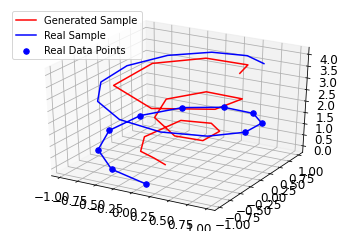

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')


ax.plot3D(X_generated[:,0], X_generated[:,1], z[0,:], 'r', label='Generated Sample')
ax.plot3D(X_real[:,0], X_real[:,1], z[0,:], 'b', label='Real Sample')
ax.scatter3D(X_real[:num_predefined, 0], X_real[:num_predefined, 1], z[0,:num_predefined], c='b', s=30, depthshade=False, label='Real Data Points')

ax.legend()
plt.show()

# Test Prediction on Test Set

In [ ]:
x_test = []
y_test = []

# generate 10 spirals
for i in range(10):
    xx, yy, zz = get_dataset()
    x_test.append(xx)
    y_test.append(yy)
    
x_test = np.array(x_test)
y_test = np.array(y_test)

x_test.shape

(10, 20)

In [ ]:
samples_num = 10
testset = []
for i in range(samples_num):
    sample_data = np.concatenate((x[i,:].reshape(-1,1), y[i,:].reshape(-1,1)), axis=1)
    #X_train_scaled = scaler.fit_transform(sample_data)*2 - 1
    testset.append(sample_data)
    #dataset.append(sample_data)

testset = np.array(testset)
testset.shape

(10, 20, 2)

Loss:  0.0068278066
<tf.Variable 'Variable:0' shape=(1, 3) dtype=float32, numpy=array([[-0.43649474,  0.38930202, -0.6982655 ]], dtype=float32)>


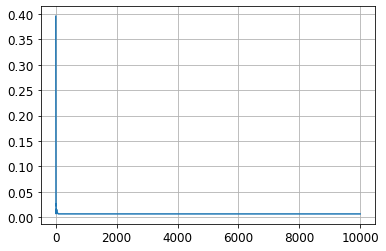

In [ ]:
n = 0
num_predefined = 10
real_coding = testset[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*num_predefined]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_size = 3
latent_values = optimize_coding(real_coding, num_predefined)
print('Loss: ', mse_loss(generator(latent_values)[:,:num_predefined,:,:], real_coding).numpy())
print(latent_values)

In [ ]:
X_generated = generator.predict(tf.convert_to_tensor(latent_values)).reshape(20,codings_size)
#X_generated = pca_compressed.inverse_transform(X_generated)
X_generated = X_generated.reshape(20, 2)

X_real = testset[n].reshape(20, codings_size)
#X_real = pca_compressed.inverse_transform(X_real)
X_real = X_real.reshape(20, 2)

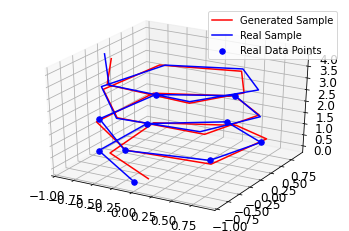

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')


ax.plot3D(X_generated[:,0], X_generated[:,1], z[0,:], 'r', label='Generated Sample')
ax.plot3D(X_real[:,0], X_real[:,1], z[0,:], 'b', label='Real Sample')
ax.scatter3D(X_real[:num_predefined, 0], X_real[:num_predefined, 1], z[0,:num_predefined], c='b', s=30, depthshade=False, label='Real Data Points')

ax.legend()
plt.show()

Loss:  0.0024836161
<tf.Variable 'Variable:0' shape=(1, 3) dtype=float32, numpy=array([[-0.94172317, -2.6495996 ,  0.8817564 ]], dtype=float32)>


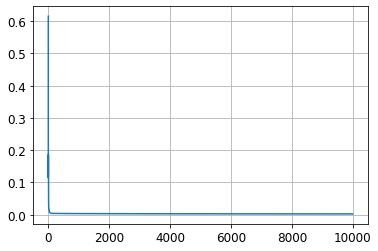

In [ ]:
n = 7
num_predefined = 10
real_coding = testset[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*num_predefined]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_size = 3
latent_values = optimize_coding(real_coding, num_predefined)
print('Loss: ', mse_loss(generator(latent_values)[:,:num_predefined,:,:], real_coding).numpy())
print(latent_values)

In [ ]:
X_generated = generator.predict(tf.convert_to_tensor(latent_values)).reshape(20,codings_size)
#X_generated = pca_compressed.inverse_transform(X_generated)
X_generated = X_generated.reshape(20, 2)

X_real = testset[n].reshape(20, codings_size)
#X_real = pca_compressed.inverse_transform(X_real)
X_real = X_real.reshape(20, 2)

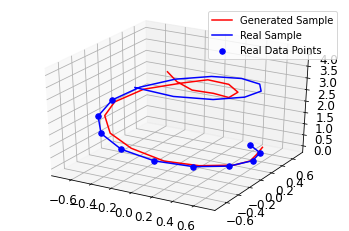

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')


ax.plot3D(X_generated[:,0], X_generated[:,1], z[0,:], 'r', label='Generated Sample')
ax.plot3D(X_real[:,0], X_real[:,1], z[0,:], 'b', label='Real Sample')
ax.scatter3D(X_real[:num_predefined, 0], X_real[:num_predefined, 1], z[0,:num_predefined], c='b', s=30, depthshade=False, label='Real Data Points')

ax.legend()
plt.show()

In [ ]:
generated = []
seed = 10
for i in range(1000):
    tf.random.set_seed(seed)
    latent_values = tf.random.normal([1, latent_space])
    generated.append(generator.predict(tf.convert_to_tensor(latent_values)).reshape(20, 2))
    seed = seed + 1

generated = np.array(generated)
generated.shape

(1000, 20, 2)

In [ ]:
generated[:,0,0].shape

(1000,)

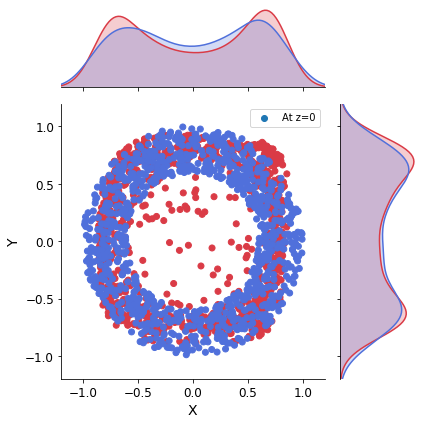

In [ ]:
new_x = np.concatenate((generated[:,0,0].reshape(1,-1), x[:,0].reshape(1,-1)),axis=1).reshape(2000,)
new_y = np.concatenate((generated[:,0,1].reshape(1,-1), y[:,0].reshape(1,-1)),axis=1).reshape(2000,)
labels = np.array([1]*1000 + [2]*1000)

# Combine data into DataFrame
df = pd.DataFrame({'X': new_x, 'Y': new_y, 'col': labels})

# Define colormap and create corresponding color palette
cmap = sns.diverging_palette(10, 260, as_cmap=True)
colors = sns.diverging_palette(10, 260, n=2)

# Plot data onto seaborn JointGrid
g = sns.JointGrid('X', 'Y', data=df, ratio=3,xlim=(-1.2, 1.2),ylim=(-1.2, 1.2))
g = g.plot_joint(plt.scatter, c=df['col'], cmap=cmap, label="At z=0")



# Loop through unique categories and plot individual kdes
for c in df['col'].unique():
    sns.kdeplot(df['Y'][df['col']==c], ax=g.ax_marg_y, vertical=True,
                color=colors[c-1], shade=True)
    sns.kdeplot(df['X'][df['col']==c], ax=g.ax_marg_x, vertical=False,
                color=colors[c-1], shade=True)
    g.ax_marg_x.legend_.remove()
    g.ax_marg_y.legend_.remove()

plt.legend()

# plt.figure(figsize=(5,5))
# plt.scatter(generated[:,0,0], generated[:,0,1], label='Generated Data at z = 0')
# plt.scatter(x[:,0], y[:,0], label = 'Real Data at z = 0')
# plt.legend()
# plt.show()

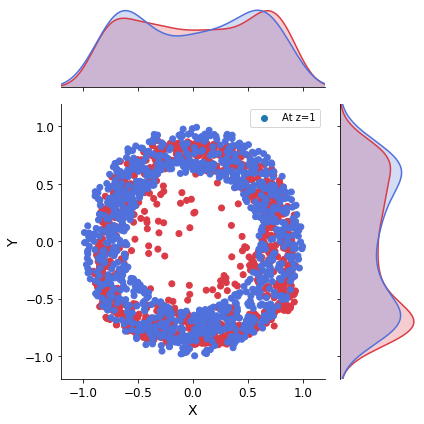

In [ ]:
new_x = np.concatenate((generated[:,10,0].reshape(1,-1), x[:,9].reshape(1,-1)),axis=1).reshape(2000,)
new_y = np.concatenate((generated[:,10,1].reshape(1,-1), y[:,9].reshape(1,-1)),axis=1).reshape(2000,)
labels = np.array([1]*1000 + [2]*1000)

# Combine data into DataFrame
df = pd.DataFrame({'X': new_x, 'Y': new_y, 'col': labels})

# Define colormap and create corresponding color palette
cmap = sns.diverging_palette(10, 260, as_cmap=True)
colors = sns.diverging_palette(10, 260, n=2)

# Plot data onto seaborn JointGrid
g = sns.JointGrid('X', 'Y', data=df, ratio=3,xlim=(-1.2, 1.2),ylim=(-1.2, 1.2))
g = g.plot_joint(plt.scatter, c=df['col'], cmap=cmap, label="At z=1")

# Loop through unique categories and plot individual kdes
for c in df['col'].unique():
    sns.kdeplot(df['Y'][df['col']==c], ax=g.ax_marg_y, vertical=True, 
                color=colors[c-1], shade=True)
    sns.kdeplot(df['X'][df['col']==c], ax=g.ax_marg_x, vertical=False, 
                color=colors[c-1], shade=True)
    g.ax_marg_x.legend_.remove()
    g.ax_marg_y.legend_.remove()

plt.legend()

# plt.figure(figsize=(5,5))
# plt.scatter(generated[:,10,0], generated[:,10,1], label='Generated Data at z = 1')
# plt.scatter(x[:,9], y[:,9], label = 'Real Data at z = 1')
# plt.legend()
# plt.show()

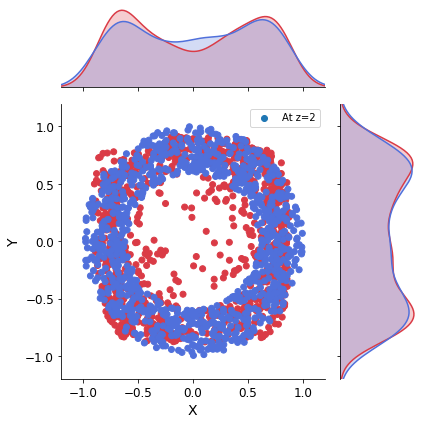

In [ ]:
new_x = np.concatenate((generated[:,-1,0].reshape(1,-1), x[:,19].reshape(1,-1)),axis=1).reshape(2000,)
new_y = np.concatenate((generated[:,-1,1].reshape(1,-1), y[:,19].reshape(1,-1)),axis=1).reshape(2000,)
labels = np.array([1]*1000 + [2]*1000)

# Combine data into DataFrame
df = pd.DataFrame({'X': new_x, 'Y': new_y, 'col': labels})

# Define colormap and create corresponding color palette
cmap = sns.diverging_palette(10, 260, as_cmap=True)
colors = sns.diverging_palette(10, 260, n=2)

# Plot data onto seaborn JointGrid
g = sns.JointGrid('X', 'Y', data=df, ratio=3,xlim=(-1.2, 1.2),ylim=(-1.2, 1.2))
g = g.plot_joint(plt.scatter, c=df['col'], cmap=cmap, label="At z=2")

# Loop through unique categories and plot individual kdes
for c in df['col'].unique():
    sns.kdeplot(df['Y'][df['col']==c], ax=g.ax_marg_y, vertical=True, 
                color=colors[c-1], shade=True)
    sns.kdeplot(df['X'][df['col']==c], ax=g.ax_marg_x, vertical=False, 
                color=colors[c-1], shade=True)
    g.ax_marg_x.legend_.remove()
    g.ax_marg_y.legend_.remove()

plt.legend()

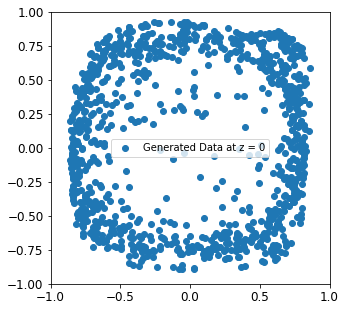

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(generated[:,0,0], generated[:,0,1], label='Generated Data at z = 0')
#plt.scatter(x[:,0], y[:,0], label = 'Real Data at z = 0')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.legend()
plt.show()

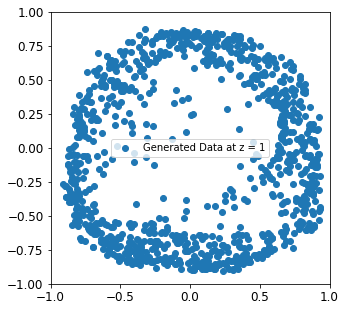

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(generated[:,10,0], generated[:,10,1], label='Generated Data at z = 1')
#plt.scatter(x[:,29], y[:,29], label = 'Real Data at z = 3')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.legend()
plt.show()

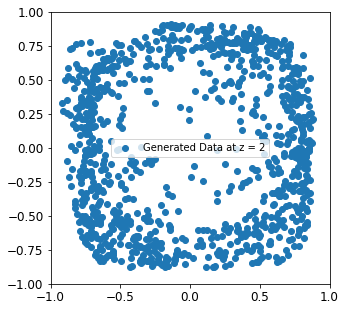

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(generated[:,19,0], generated[:,19,1], label='Generated Data at z = 2')
#plt.scatter(x[:,9], y[:,9], label = 'Real Data at z = 1')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.legend()
plt.show()